In [1]:
from unityagents import UnityEnvironment
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ddpg_agent_testing import DDPGMultiAgent
from utils import VisWriter, save_to_txt
writer = VisWriter(vis=False)

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
agent = DDPGMultiAgent(state_size, action_size, num_agents, writer=writer, random_seed=10, 
                        dirname="output", print_every=100, model_path=None)

INFO:ddpg_multi:Initialised with random seed: 10


In [6]:
def ddpg(env, brain_name, num_agents, agent, writer, n_episodes=300, max_t=1000, print_every=100, stop_on_solve=True):

    best_score = -np.inf
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)            
            dones = env_info.local_done                        # see if episode finished
            score += env_info.rewards                          # update the score (for each agent)
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        current_score = np.mean(scores_deque)

        if current_score > best_score:
            best_score = current_score
            agent.checkpoint()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, current_score))

        # check environment solved
        if current_score >= 0.5:
            print('Environment solved in {} episodes'.format(i_episode))
            if stop_on_solve:
                break
            
    print('Final Average Score: {:.2f}'.format(current_score))
    return scores

In [7]:
scores = ddpg(env, brain_name, num_agents, agent, writer=writer, n_episodes=10000, max_t=100, stop_on_solve=True)

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.03
Episode 400	Average Score: 0.04
Episode 500	Average Score: 0.05
Episode 600	Average Score: 0.05
Episode 700	Average Score: 0.05
Episode 800	Average Score: 0.05
Episode 900	Average Score: 0.05
Episode 1000	Average Score: 0.02
Episode 1100	Average Score: 0.07
Episode 1200	Average Score: 0.12
Episode 1300	Average Score: 0.13
Episode 1400	Average Score: 0.14
Episode 1500	Average Score: 0.15
Episode 1600	Average Score: 0.14
Episode 1700	Average Score: 0.14
Episode 1800	Average Score: 0.15
Episode 1900	Average Score: 0.18
Episode 2000	Average Score: 0.18
Episode 2100	Average Score: 0.24
Episode 2200	Average Score: 0.25
Episode 2300	Average Score: 0.21
Episode 2400	Average Score: 0.20
Episode 2500	Average Score: 0.18
Episode 2600	Average Score: 0.21
Episode 2700	Average Score: 0.25
Episode 2800	Average Score: 0.23
Episode 2900	Average Score: 0.23
Episode 3000	Average Score: 0.25
Episode 3100	Averag

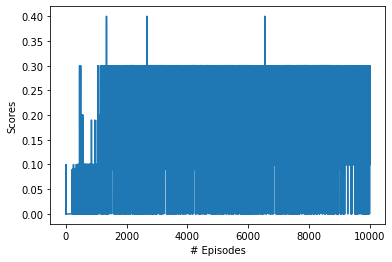

In [8]:
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel('# Episodes')
plt.ylabel('Scores')
plt.savefig('output/ddpg_scores_plot.png')
plt.show()